<a href="https://colab.research.google.com/github/hristina6/VNP/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Change and Trade Patterns: Use UN Comtrade, OECD Statistics, and World Bank data to study how global trade patterns are shifting in response to climate change and what implications this has for economic sustainability**

Import на потребните библиотеки

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests

Дефинирање на потребните индикатори

In [ ]:
climate_indicators = {
    "EN.ATM.CO2E.PC": "CO2 Emissions per Capita",
    "EN.ATM.METH.AG.ZS": "Agricultural Methane Emissions (% of total)",
    "AG.LND.PRCP.MM": "Annual Precipitation (mm)"
}
trade_indicators = {
    "NE.TRD.GNFS.ZS": "Trade as % of GDP",
    "NE.EXP.GNFS.CD": "Exports of Goods and Services (Current USD)",
    "NE.IMP.GNFS.CD": "Imports of Goods and Services (Current USD)"
}
countries = ["USA", "CHN", "IND"]

Дефинирање на ранг за опфатените годините

In [ ]:
years = [str(year) for year in range(2000, 2023)]

Повлекување на податоците од World Bank

In [ ]:
def fetch_data_from_api(indicators, countries):
    data = []
    for indicator, indicator_name in indicators.items():
        for country in countries:
            url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date=2000:2023&format=json'
            response = requests.get(url)
            if response.status_code == 200:
                json_data = response.json()[1]
                for entry in json_data:
                    data.append({
                        "Country Code": entry["country"]["id"],
                        "Country Name": entry["country"]["value"],
                        "Indicator Code": entry["indicator"]["id"],
                        "Indicator Name": indicator_name,
                        "Year": entry["date"],
                        "Value": entry["value"]
                    })
            else:
                print(f"Failed to fetch data for {indicator} in {country}")
    return pd.DataFrame(data)

In [ ]:
climate_data = fetch_data_from_api(climate_indicators, countries)
trade_data = fetch_data_from_api(trade_indicators, countries)

In [ ]:
def process_api_data(df, indicators):
    df = df[df["Indicator Code"].isin(indicators.keys())]
    df["Indicator Name"] = df["Indicator Code"].map(indicators)
    df = df.pivot_table(index=["Country Code", "Country Name", "Year"], columns="Indicator Name", values="Value").reset_index()
    return df

In [ ]:
climate_df = process_api_data(climate_data, climate_indicators)
trade_df = process_api_data(trade_data, trade_indicators)

Merge на двете табели според одредените колони

In [ ]:
merged_df = pd.merge(climate_df, trade_df, on=["Country Code", "Country Name", "Year"])

In [ ]:
merged_df

Indicator Name,Country Code,Country Name,Year,Agricultural Methane Emissions (% of total),Annual Precipitation (mm),CO2 Emissions per Capita,Exports of Goods and Services (Current USD),Imports of Goods and Services (Current USD),Trade as % of GDP
0,CN,China,2000,44.947626,645.0,2.650409,2.530921e+11,2.243062e+11,39.411034
1,CN,China,2001,43.989711,645.0,2.774762,2.720600e+11,2.439738e+11,38.527210
2,CN,China,2002,43.098464,645.0,2.964821,3.330023e+11,2.956196e+11,42.747182
3,CN,China,2003,42.219117,645.0,3.434036,4.479583e+11,4.121371e+11,51.804220
4,CN,China,2004,42.587682,645.0,3.945155,6.073569e+11,5.561826e+11,59.505531
...,...,...,...,...,...,...,...,...,...
58,US,United States,2016,NaN,715.0,15.149883,2.235558e+12,2.738830e+12,26.452598
59,US,United States,2017,NaN,715.0,14.823245,2.388260e+12,2.931589e+12,27.125338
60,US,United States,2018,NaN,715.0,15.222518,2.538089e+12,3.131166e+12,27.445359
61,US,United States,2019,NaN,715.0,14.673381,2.538450e+12,3.116954e+12,26.278055


Претставување на поврзаноста на податоците

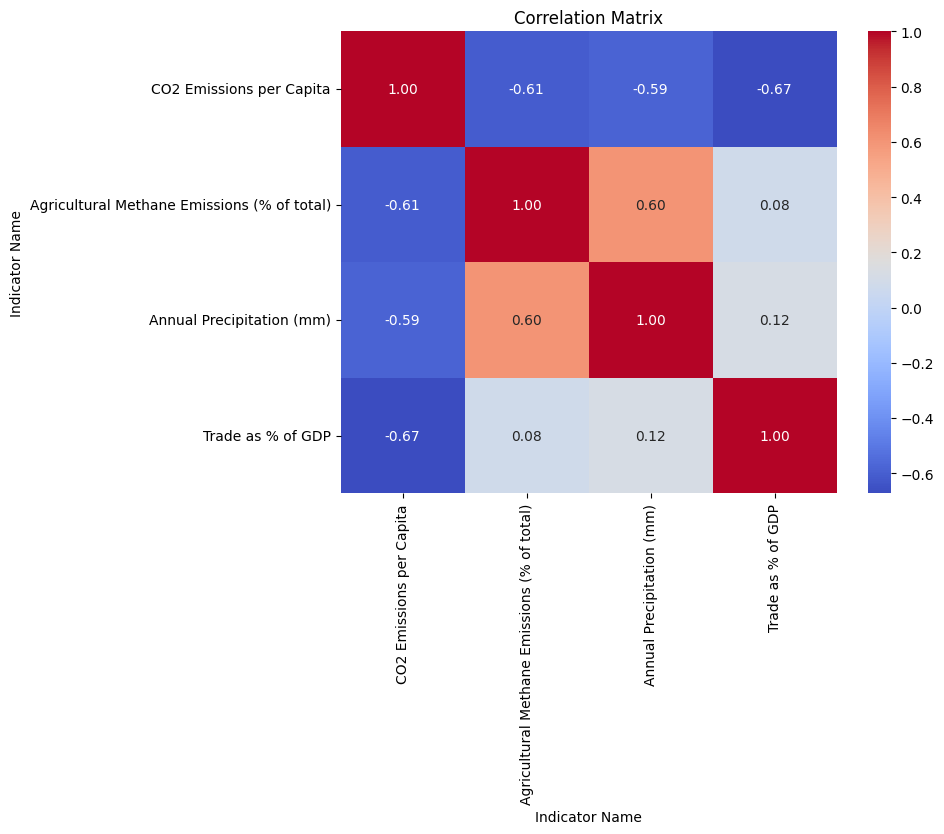

In [ ]:
import seaborn as sns
corr_matrix = merged_df[['CO2 Emissions per Capita', 'Agricultural Methane Emissions (% of total)',
                         'Annual Precipitation (mm)', 'Trade as % of GDP']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Проверка на missing values

In [ ]:
merged_df.isnull().sum()

Indicator Name
Country Code                                    0
Country Name                                    0
Year                                            0
Agricultural Methane Emissions (% of total)    36
Annual Precipitation (mm)                       0
CO2 Emissions per Capita                        0
Exports of Goods and Services (Current USD)     0
Imports of Goods and Services (Current USD)     0
Trade as % of GDP                               0
dtype: int64

In [ ]:
merged_df['Agricultural Methane Emissions (% of total)'].fillna(merged_df['Agricultural Methane Emissions (% of total)'].mean(), inplace=True)

In [ ]:
merged_df.isnull().sum()

Indicator Name
Country Code                                   0
Country Name                                   0
Year                                           0
Agricultural Methane Emissions (% of total)    0
Annual Precipitation (mm)                      0
CO2 Emissions per Capita                       0
Exports of Goods and Services (Current USD)    0
Imports of Goods and Services (Current USD)    0
Trade as % of GDP                              0
dtype: int64

Поделба на податоците

In [ ]:
X = merged_df[list(climate_indicators.values())]
y = merged_df[list(trade_indicators.values())]

Скалирање на податоците

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Split на дата

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Train и користење на линеар регресор

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Evaluete на моделот

In [ ]:
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score

# Evaluate the model using R2 score
r2 = r2_score(y_test, y_pred)
r2

0.6167185205565953

Plot bar за Actual vs Predicted Values

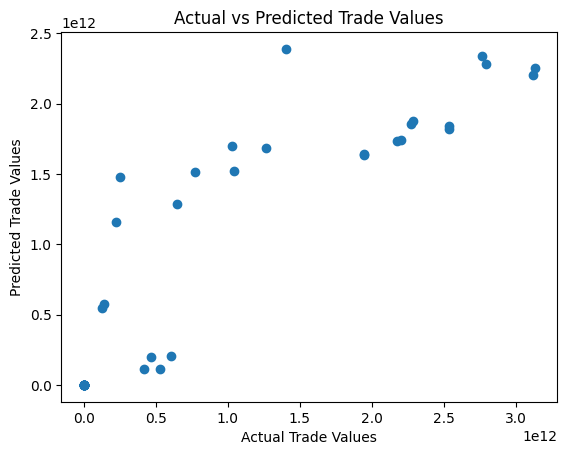

In [ ]:
plt.scatter(y_test.values.flatten(), y_pred.flatten())
plt.xlabel("Actual Trade Values")
plt.ylabel("Predicted Trade Values")
plt.title("Actual vs Predicted Trade Values")
plt.show()